# Binary Ensembler:
The Binary Ensembler Trains multiple LSTM and Random Forests and stores them in an object. The code preprocesses a dataset for each of the given labels based on a correlation threshold (only applied to categorical features currently). Then it trains a LSTM and Random Forest on each set and prints the evaluations for each label. Has options for 
a downsampled dataset and the full dataset.

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import os
import time
from sklearn.utils.class_weight import compute_class_weight
import random
import shap
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random

In [22]:
def plot_metrics(train, val, epochs, title):
    """
    Plot the training, validation, and test metrics.

    Parameters:
        - train_loss (list): Training metric.
        - val_loss (list): Validation metric.
        - test_loss (list): Test tmetric.
        - epochs (int): The number of epochs.
        - title (string): The title of the plot (imputes the category with type of plot).
    """

    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, epochs + 1), train, label='Training', color=sns.color_palette("pastel")[0])
    plt.plot(range(1, epochs + 1), val, label='Validation', color=sns.color_palette("pastel")[1])
    plt.xlabel('Epochs')
    plt.ylabel(f"{title}")
    plt.title(f"{title}")
    plt.legend()
    plt.ylim(bottom=0)
    plt.show()

In [23]:
class CorrEncoder:
    """
    CorrEncoder: Takes a dataset as input and uses it for the encode function. Encodes the filtered categories then draws correlations.
    If correlation is above the threshold adds it to a new dataframe then returns the one hot encoded values with the labels.

    Initialisation:
        - data (pd.DataFrame): The Dataset that contains the target column and target label variables.
    """
    
    def __init__(self, data):
        self.data = data.copy()
        # Removes Label for the binary processing as it is based on the specific attack_cat.
        self.data = self.data.drop(columns=['Label'])

    def encode(self, target_column, sparse_n, threshold, cat):
        """
        encode: Takes a target column and target label to encode and draw correlations from. The target column is iterated through
        for all categories that contain more positive values than defined in sparse_n. This allows for filtering of sparse categories.
        The function then one hot encodes the given category with the static target column and draws correlations for them. If correlation
        is greater then threshold then add it to the new DataFrame. The function returns the one hot encoded categories that pass the
        threshold with the target label.

        The purpose of this function is to resolve the high cardinality problem in one hot encoding.

        Parameters:
            - target_column (string): The name of the target column. The target column should contain the various categories to encode.
            - sparse_n (integer): The minimum amount of positive values required for a category after encoding (deals with sparse categories).
            - threshold (float): The threshold for correlation. The function creates onehot encoded columns of all variables that high correlation
              higher that the threshold to the target label.
            - cat (string): The category label to compare to.

        Returns:
            - ohe_df (pd.DataFrame): The one hot encoded values from the target columns.
        """

        # Convert to string to handle duplicates.
        self.data[target_column] = self.data[target_column].astype(str)
        value_counts = self.data[target_column].value_counts()
        # Check if number of 1s is above the given threshold set by sparse_n.
        categories = value_counts[value_counts > sparse_n].index.tolist()
        ohe_list = []

        # Convert the target label to one hot encoded.
        attack_cat = (self.data['attack_cat'] == cat).astype(int)
        # Go through each unique category in the target column.
        for c in categories:
            col_name = f'{target_column}_{c}'

            # Create the binary encoding column for the current category and target label
            corr_column = (self.data[target_column] == c).astype(int)
            correlation = corr_column.corr(attack_cat)

            # Check if absolute correlation is greater than threshold.
            if abs(correlation) > threshold:
                corr_column.name = col_name
                ohe_list.append(corr_column)
        if ohe_list:
            # NOTE: This section can be expanded to include print outs but at the moment am focusing on the evaluations.
            ohe_df = pd.concat(ohe_list, axis=1)
            return ohe_df
        else:
            # This ommits errors (if really high thresholds are used).
            print("No correlations exceed the threshold.")
            return pd.DataFrame()

In [1]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE  # For SMOTE upsampling
from sklearn.model_selection import train_test_split
import random

class DataSamplerBinary:
    """
    DataSamplerBinary3: Preprocesses data for the LSTM and Random Forest for a given label category. Uses down-sampling with a mask to reduce the Normal labels by a given percentage,
    ensuring that no Normal values adjacent to a threat row are removed. Alternatively uses the full data or upsampling with SMOTE. Preprocesses and encodes the categories by filtering
    categories with correlation below a given threshold. Creates tensors for the LSTM and stores the data for referencing through the ensembler.

    Initialisation:
        - train (None): The attribute that stores the train tensor.
        - val(None): The attribute that stores the train tensor.
        - test (None): The attribute that stores the train tensor.
        - name (string): The name of the label category.
    """
    
    def __init__(self):
        self.train = None
        self.val = None
        self.test = None
        self.name = None

    def get_data(self, type_of, size, rs, category, threshold, downsample_percentage=None, split_method='slice'):
        """
        get_data: Preprocess and transform data for the LSTM and Random Forest. Combines the 4 USNW-NB15 datasets and downsamples the Normal labels by a given percentage,
        ensuring that no Normal values adjacent to a threat row are removed. Alternatively uses the full data or upsampling with SMOTE. One hot encodes the categories using a given
        threshold for correlation through the CorrEncoder class. Scales the data and then splits a train, validation, and test set using either slicing or shuffling. Finally creates
        and returns tensors with an added dimension for the LSTM. The class stores the datasets as attributes for referencing.

        Parameters:
            - type_of (string): The type of preprocessing to use. Options are 'downsample', 'upsample', or 'full'.
            - size (float): The proportion for the validation and test set (same size).
            - rs (int): The random seed to use for the slicing, shuffling, and SMOTE.
            - category (string): The label category to preprocess.
            - threshold (float): The threshold value for the minimum correlation in one hot encoded categories.
            - downsample_percentage (float): The percentage of "Normal" labels to downsample (e.g., 0.5 for 50%). Only used if type_of='downsample'.
            - split_method (string): The method to split the data into train, validation, and test sets. Options are 'slice' (default) or 'shuffle'.
        
        Returns:
            - train_dataset (tensor): The training tensor given as (rows, sequence, features).
            - val_dataset (tensor): The validation tensor given as (rows, sequence, features).
            - test_dataset (tensor): The testing tensor given as (rows, sequence, features).        
        """

        # Combine datasets and preprocess.
        # NOTE: The null values are converted to Normal labels.
        feature_names = pd.read_csv('features2.csv')
        self.name = category
        feature_names_list = feature_names['Name'].tolist()
        s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
        s1.columns = feature_names_list
        s1.loc[s1['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

        feature_names_list = feature_names['Name'].tolist()
        s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)
        s2.columns = feature_names_list
        s2.loc[s2['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

        feature_names_list = feature_names['Name'].tolist()
        s3 = pd.read_csv('UNSW-NB15_3.csv', header=None)
        s3.columns = feature_names_list
        s3.loc[s3['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

        feature_names_list = feature_names['Name'].tolist()
        s4 = pd.read_csv('UNSW-NB15_4.csv', header=None)
        s4.columns = feature_names_list
        s4.loc[s4['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
        
        i = 0
        data = [s1, s2, s3, s4]
        # If downsampling is chosen, downsample the Normal labels by the given percentage, ensuring no Normal values adjacent to a threat row are removed.
        if type_of == 'downsample' and downsample_percentage is not None:
            while i < len(data):
                df = data[i]
                # Create a mask to identify Normal rows that are NOT adjacent to a threat row.
                mask = (df['Label'].shift(-1) != 1) & (df['Label'].shift(1) != 1)
                normal_rows = df[(df['attack_cat'] == 'Normal') & mask]
                num_to_remove = int(len(normal_rows) * downsample_percentage)
                rows_to_remove = normal_rows.sample(n=num_to_remove, random_state=rs)
                df = df.drop(rows_to_remove.index)
                data[i] = df
                i += 1

        # Combine the datasets
        full_data = pd.concat([data[0], data[1], data[2], data[3]]).reset_index(drop=True)

        # Clean Labels and drop sparse data.
        full_data['attack_cat'] = full_data['attack_cat'].str.replace(r'\s+', '', regex=True)
        full_data['attack_cat'] = full_data['attack_cat'].str.replace('Backdoors', 'Backdoor')
        full_data = full_data.drop(columns=['ct_ftp_cmd', 'ct_flw_http_mthd', 'is_ftp_login'])
        # Clean error values (imported as hex strings for some reason).
        full_data = full_data[~full_data['sport'].astype(str).str.startswith('0x')]
        full_data = full_data[~full_data['sport'].astype(str).str.startswith('-')]
        full_data['sport'] = full_data['sport'].apply(pd.to_numeric)
        full_data = full_data[~full_data['dsport'].astype(str).str.startswith('0x')]
        full_data = full_data[~full_data['dsport'].astype(str).str.startswith('-')]
        full_data['dsport'] = full_data['dsport'].apply(pd.to_numeric)

        columns = ['state', 'service']
        encoder = OneHotEncoder(sparse_output=False, dtype='float32')
        encoded_data = encoder.fit_transform(full_data[columns])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns), index=full_data.index)
        full_encoded = pd.concat([full_data.drop(columns=columns), encoded_df], axis=1)
        encoder = CorrEncoder(full_encoded)
        ohe1 = encoder.encode('dsport', 30, threshold, category)
        ohe2 = encoder.encode('proto', 30, threshold, category)
        ohe3 = encoder.encode('sport', 30, threshold, category)
        ohe4 = encoder.encode('srcip', 30, threshold, category)
        ohe5 = encoder.encode('dstip', 30, threshold, category)
        cols_to_drop = ['dsport', 'proto', 'sport', 'srcip', 'dstip']
        filtered_data = full_encoded.drop(columns=cols_to_drop)
        combined_data = pd.concat([filtered_data, ohe1, ohe2, ohe3, ohe4, ohe5], axis=1)
        # NOTE: There is no need for LabelEncoder here as we know threat = 1 and rest = 0.
        combined_data['attack_cat'] = (combined_data['attack_cat'] == category).astype(int)
        df_features = combined_data.drop(columns=['attack_cat', 'Label'])
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df_features)
        final_data = pd.DataFrame(scaled_data, columns=df_features.columns, index=combined_data.index)
        final_data['attack_cat'] = combined_data['attack_cat']

        random.seed(rs)

        if type_of == 'upsample':
            smote = SMOTE(random_state=rs)
            X_resampled, y_resampled = smote.fit_resample(final_data.drop(columns=['attack_cat']), final_data['attack_cat'])
            final_data = pd.concat([pd.DataFrame(X_resampled, columns=final_data.drop(columns=['attack_cat']).columns),
                                   pd.Series(y_resampled, name='attack_cat')], axis=1)
        if split_method == 'slice':
            slice_size = int(size * len(final_data))
            val_start = random.randrange(0, len(final_data) - 2 * slice_size)
            val_end = val_start + slice_size
            val_data = final_data.iloc[val_start:val_end]
            df = final_data.drop(val_data.index)
            test_start = random.randrange(0, len(df) - slice_size)
            test_end = test_start + slice_size
            test_data = df.iloc[test_start:test_end]
            train_data = df.drop(test_data.index)
        elif split_method == 'shuffle':
            train_data, temp_data = train_test_split(final_data, test_size=2 * size, random_state=rs)
            val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=rs)
        else:
            raise ValueError("Invalid split_method. Choose 'slice' or 'shuffle'.")

        self.train = train_data
        self.val = val_data
        self.test = test_data

        return train_data, val_data, test_data

KeyboardInterrupt: 

In [ ]:
class SimpleNN(nn.Module):
    """
    BinaryFC: A simple Fully Connected neural network with two layers and ReLU activation. 
    Trains and validates the model, then tests it and stores the evaluation metrics as attributes.
    """
    def __init__(self, input_size, hidden_size, device, save_dir, name):
        super(SimpleNN, self).__init__()
        self.name = name
        self.device = device  # Store device (CPU or GPU)
        self.save_dir = save_dir

        # Fully Connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Single output unit for binary classification
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Move model to the appropriate device (GPU/CPU)
        self.to(self.device)

        # To store loss and metrics
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.epoch_time = []
        self.test_accuracy = None
        self.test_loss = None
        self.test_f1 = None
        self.test_predicted = []
        self.test_actual = []

    def forward(self, x):
        """
        Forward pass for the Fully Connected model.
        
        Parameters:
            - x (tensor): The input features.
        
        Returns:
            - output (tensor): The output after the second fully connected layer with Sigmoid.
        """
        x = self.relu(self.fc1(x))  # Apply ReLU activation after first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer
        output = self.sigmoid(x)  # Apply Sigmoid activation to output for binary classification
        return output

    def calculate_accuracy_f1(self, predictions, labels):
        """
        Calculate accuracy and F1 score.
        
        Parameters:
            - predictions (tensor): The predictions given by the model.
            - labels (tensor): The true labels.
        
        Returns:
            - accuracy (float): The accuracy score.
            - f1 (float): The weighted F1 score.
        """
        preds = (predictions > 0.5).float()  # Apply threshold to sigmoid outputs (0.5 for binary)
        accuracy = accuracy_score(labels.cpu(), preds.cpu())  # Calculate accuracy
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')  # Calculate weighted F1 score
        return accuracy, f1

    def run(self, train_data, val_data, test_data, criterion, optimizer, epochs, save_factor):
        """
        Train, validate, and test the model.
        
        Parameters:
            - train_data (TensorDataset): The training dataset (features + labels).
            - val_data (TensorDataset): The validation dataset (features + labels).
            - test_data (TensorDataset): The test dataset (features + labels).
            - criterion (nn.BCEWithLogitsLoss): The loss function for binary classification.
            - optimizer (optim.Adam): The optimizer for training.
            - epochs (int): The number of epochs to train.
            - save_factor (int): The factor at which to save the model during training.
        
        Returns:
            - explainer (shap.GradientExplainer): The SHAP explainer for the test data.
        """
        train_seq, train_label = train_data.tensors
        val_seq, val_label = val_data.tensors
        test_seq, test_label = test_data.tensors

        train_seq, train_label = train_seq.to(self.device), train_label.to(self.device)
        val_seq, val_label = val_seq.to(self.device), val_label.to(self.device)
        test_seq, test_label = test_seq.to(self.device), test_label.to(self.device)

        for epoch in range(epochs):
            start_time = time.time()
            self.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = self(train_seq)
            loss = criterion(outputs.squeeze(), train_label)
            loss.backward()
            optimizer.step()
            train_accuracy, train_f1 = self.calculate_accuracy_f1(outputs, train_label)
            self.eval()
            with torch.no_grad():
                val_outputs = self(val_seq)
                val_loss = criterion(val_outputs.squeeze(), val_label)
                val_accuracy, val_f1 = self.calculate_accuracy_f1(val_outputs, val_label)

            self.train_loss.append(loss.item())
            self.val_loss.append(val_loss.item())
            self.train_accuracy.append(train_accuracy)
            self.val_accuracy.append(val_accuracy)
            self.train_f1.append(train_f1)
            self.val_f1.append(val_f1)

            epoch_time = time.time() - start_time
            self.epoch_time.append(epoch_time)

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
            print(f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)
        self.eval()
        with torch.no_grad():
            test_outputs = self(test_seq)
            test_loss = criterion(test_outputs.squeeze(), test_label)
            test_accuracy, test_f1 = self.calculate_accuracy_f1(test_outputs, test_label)
            self.test_accuracy = test_accuracy
            self.test_loss = test_loss.item()
            self.test_f1 = test_f1

            self.test_pred = (torch.sigmoid(test_outputs) > 0.5).cpu().numpy()
            self.test_actual = test_label.cpu().numpy()
            print(f"Test Loss: {self.test_loss:.4f}, Test Accuracy: {self.test_accuracy:.4f}, Test F1: {self.test_f1:.4f}")

        # SHAP explanation using the gradient-based explainer
        explainer = shap.GradientExplainer(self, test_seq)
        return explainer

    def save_model(self, epoch):
        """
        Save the model state_dict for the given epoch.
        
        Parameters:
            - epoch (int): The current epoch.
        """
        checkpoint_path = os.path.join(self.save_dir, f"fc_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
        }, checkpoint_path)

    def load_model(self, epoch):
        """
        Load a state_dict of a model.
        
        Parameters:
            - epoch (int): The epoch to load.
        """
        checkpoint_path = os.path.join(self.save_dir, f"fc_epoch_{epoch}.pt")
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint['model_state_dict'])

In [28]:
class BinaryEnsembler:
    """
    BinaryEnsembler: Creates an ensemble of Binary LSTM and Binary Random Forests and stores them as attributes along with the given data. The models are stored as attributes
    allowing referencing to the models attributes.

    Initialisation:
        - 
    """
    def __init__(self, labels, hidden_size, num_layers, epochs, threshold, learning_rate):
        self.labels = labels
        self.data_ensemble = []
        self.model_ensemble = []
        self.explainers_ensemble = []
        self.tree_ensemble = []
        self.model_accuracy = 0
        self.tree_accuracy = 0
        for label in self.labels:
            ds = DataSamplerBinary()
            train_data, val_data, test_data = ds.get_data('downsample', 0.15, 42, label, threshold)
            self.data_ensemble.append(ds)
            device = torch.device("cpu")
            input_size = train_data.tensors[0].shape[2]
            model = BinaryLSTM(input_size, hidden_size, num_layers, device, 'model', label)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            explainer = model.run(train_data, val_data, test_data, criterion, optimizer, epochs, 50)
            self.model_ensemble.append(model)
            self.explainers_ensemble.append(explainer)
            # All metrics are held within the model and can be called.
            plot_metrics(model.train_loss, model.val_loss, epochs, label + ' Loss')
            plot_metrics(model.train_f1, model.val_f1, epochs, label + ' F1')
            plot_metrics(model.train_accuracy, model.val_accuracy, epochs, label + ' Accuracy')
            # There is only 1 time but omits errors if wanting to just plot 1.
            plot_metrics(model.epoch_time, model.epoch_time, epochs, label + ' Time')
            tr_data, labels = train_data.tensors
            tr_data = tr_data.squeeze()
            tr_data = pd.DataFrame(tr_data)
            tr_data['labels'] = pd.DataFrame(labels)
            te_data, labels = test_data.tensors
            te_data = te_data.squeeze()
            te_data = pd.DataFrame(te_data)
            te_data['labels'] = pd.DataFrame(labels)
            X_train = tr_data.drop(columns='labels')
            y_train = tr_data['labels']
            X_test = te_data.drop(columns='labels')
            y_test = te_data['labels']
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            self.model_accuracy += model.test_accuracy
            self.tree_accuracy += accuracy
            print(f"{label} Accuracy: {accuracy:.4f}")
            print('\nClassification Report:')
            print(classification_report(y_test, y_pred))
        print('Average LSTM Accuracy')
        print(self.model_accuracy/len(self.labels))
        print('Average Random Forest Accuracy')
        print(self.tree_accuracy/len(self.labels))

C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


Epoch [1/100], Train Loss: 0.7335, Train Accuracy: 0.0336, Train F1: 0.0022
Val Loss: 0.2213, Val Accuracy: 0.9780, Val F1: 0.9672
Epoch [2/100], Train Loss: 0.2502, Train Accuracy: 0.9664, Train F1: 0.9499
Val Loss: 0.0993, Val Accuracy: 0.9780, Val F1: 0.9672
Epoch [3/100], Train Loss: 0.1485, Train Accuracy: 0.9664, Train F1: 0.9499
Val Loss: 0.1188, Val Accuracy: 0.9780, Val F1: 0.9672
Epoch [4/100], Train Loss: 0.1796, Train Accuracy: 0.9664, Train F1: 0.9499
Val Loss: 0.1187, Val Accuracy: 0.9780, Val F1: 0.9672
Epoch [5/100], Train Loss: 0.1774, Train Accuracy: 0.9664, Train F1: 0.9499
Val Loss: 0.1015, Val Accuracy: 0.9780, Val F1: 0.9672
Epoch [6/100], Train Loss: 0.1489, Train Accuracy: 0.9664, Train F1: 0.9499
Val Loss: 0.0791, Val Accuracy: 0.9780, Val F1: 0.9672
Epoch [7/100], Train Loss: 0.1139, Train Accuracy: 0.9664, Train F1: 0.9499
Val Loss: 0.0669, Val Accuracy: 0.9773, Val F1: 0.9684
Epoch [8/100], Train Loss: 0.0975, Train Accuracy: 0.9640, Train F1: 0.9534
Val Los

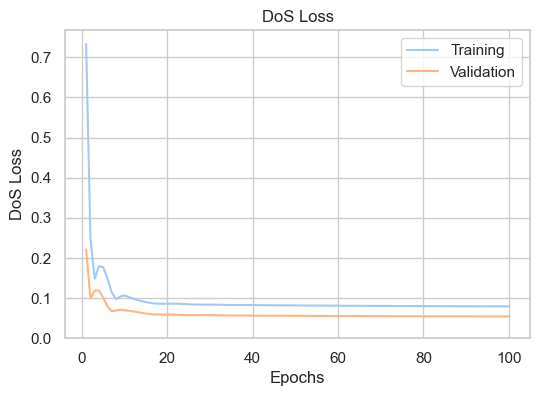

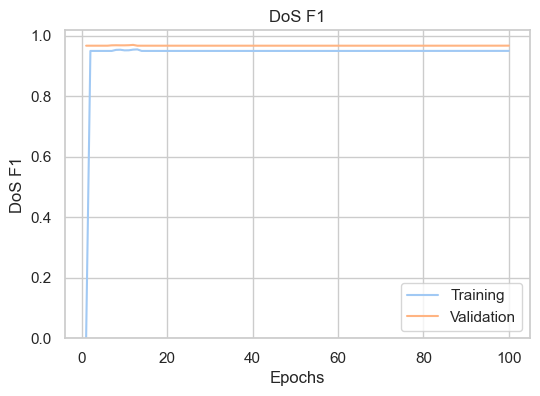

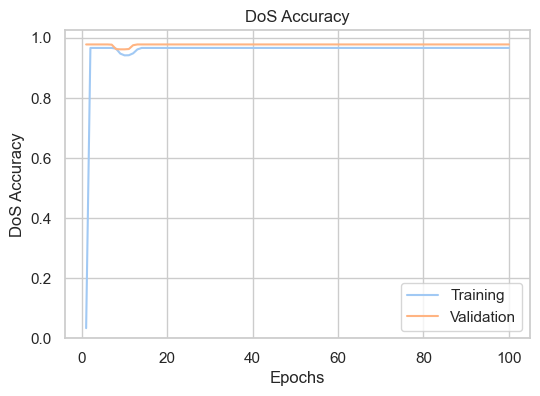

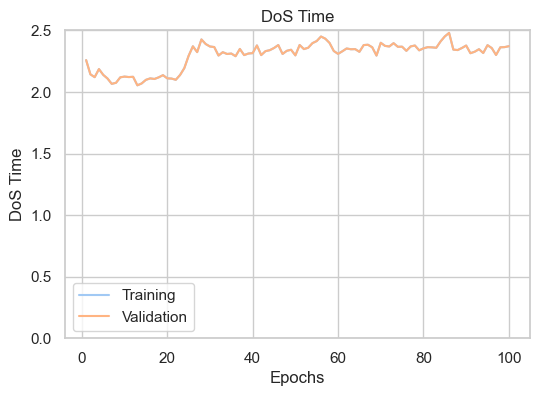

DoS Accuracy: 0.9764

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     78550
         1.0       0.89      0.03      0.06      1954

    accuracy                           0.98     80504
   macro avg       0.93      0.52      0.53     80504
weighted avg       0.97      0.98      0.97     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


Epoch [1/100], Train Loss: 0.6754, Train Accuracy: 0.9511, Train F1: 0.9274
Val Loss: 0.2077, Val Accuracy: 0.9617, Val F1: 0.9429
Epoch [2/100], Train Loss: 0.2253, Train Accuracy: 0.9510, Train F1: 0.9271
Val Loss: 0.1954, Val Accuracy: 0.9617, Val F1: 0.9429
Epoch [3/100], Train Loss: 0.2352, Train Accuracy: 0.9510, Train F1: 0.9271
Val Loss: 0.1975, Val Accuracy: 0.9617, Val F1: 0.9429
Epoch [4/100], Train Loss: 0.2369, Train Accuracy: 0.9510, Train F1: 0.9271
Val Loss: 0.1499, Val Accuracy: 0.9617, Val F1: 0.9429
Epoch [5/100], Train Loss: 0.1770, Train Accuracy: 0.9510, Train F1: 0.9271
Val Loss: 0.1108, Val Accuracy: 0.9618, Val F1: 0.9431
Epoch [6/100], Train Loss: 0.1268, Train Accuracy: 0.9539, Train F1: 0.9344
Val Loss: 0.1556, Val Accuracy: 0.9624, Val F1: 0.9634
Epoch [7/100], Train Loss: 0.1694, Train Accuracy: 0.9484, Train F1: 0.9509
Val Loss: 0.1163, Val Accuracy: 0.9725, Val F1: 0.9714
Epoch [8/100], Train Loss: 0.1296, Train Accuracy: 0.9634, Train F1: 0.9628
Val Los

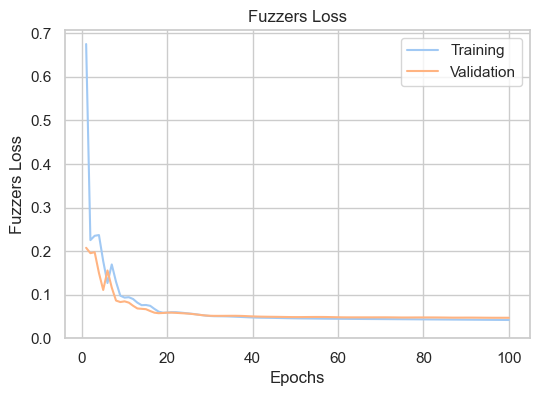

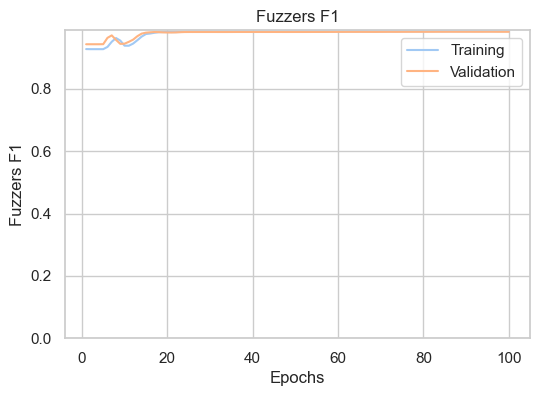

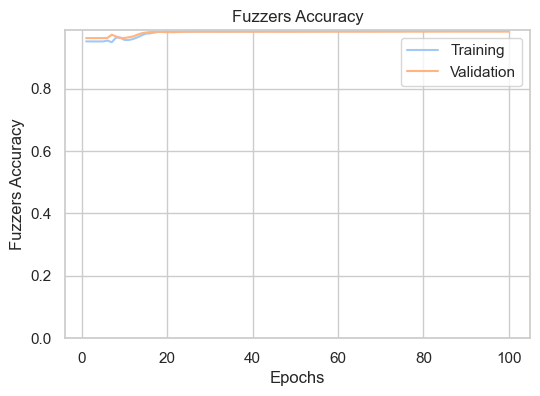

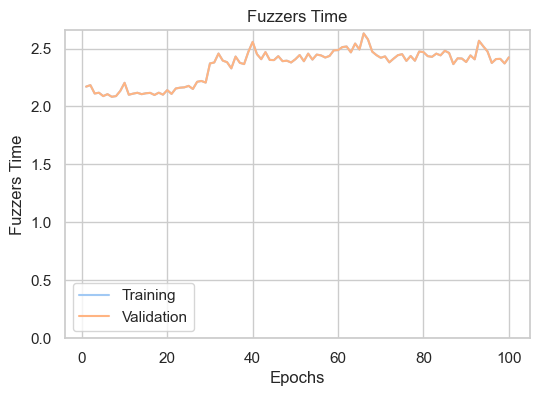

Fuzzers Accuracy: 0.9865

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     77746
         1.0       0.76      0.88      0.82      2758

    accuracy                           0.99     80504
   macro avg       0.88      0.93      0.90     80504
weighted avg       0.99      0.99      0.99     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


Epoch [1/100], Train Loss: 0.6993, Train Accuracy: 0.3768, Train F1: 0.2062
Val Loss: 0.3307, Val Accuracy: 0.9211, Val F1: 0.9207
Epoch [2/100], Train Loss: 0.3309, Train Accuracy: 0.9133, Train F1: 0.9143
Val Loss: 0.1227, Val Accuracy: 0.9473, Val F1: 0.9472
Epoch [3/100], Train Loss: 0.1806, Train Accuracy: 0.9199, Train F1: 0.9208
Val Loss: 0.1669, Val Accuracy: 0.9844, Val F1: 0.9844
Epoch [4/100], Train Loss: 0.1099, Train Accuracy: 0.9824, Train F1: 0.9823
Val Loss: 0.4148, Val Accuracy: 0.7696, Val F1: 0.7578
Epoch [5/100], Train Loss: 0.1322, Train Accuracy: 0.9798, Train F1: 0.9797
Val Loss: 0.1173, Val Accuracy: 0.9915, Val F1: 0.9915
Epoch [6/100], Train Loss: 0.1171, Train Accuracy: 0.9850, Train F1: 0.9850
Val Loss: 0.0826, Val Accuracy: 0.9914, Val F1: 0.9914
Epoch [7/100], Train Loss: 0.1126, Train Accuracy: 0.9859, Train F1: 0.9859
Val Loss: 0.0806, Val Accuracy: 0.9892, Val F1: 0.9892
Epoch [8/100], Train Loss: 0.1120, Train Accuracy: 0.9857, Train F1: 0.9856
Val Los

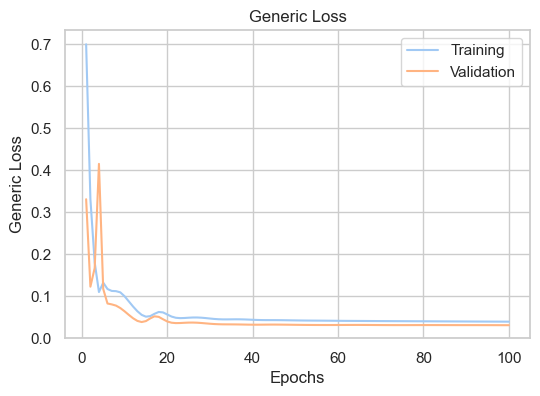

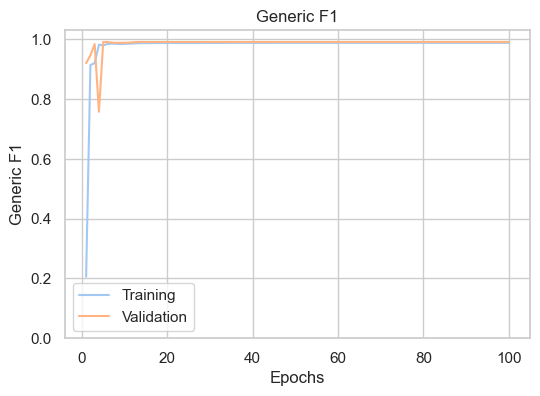

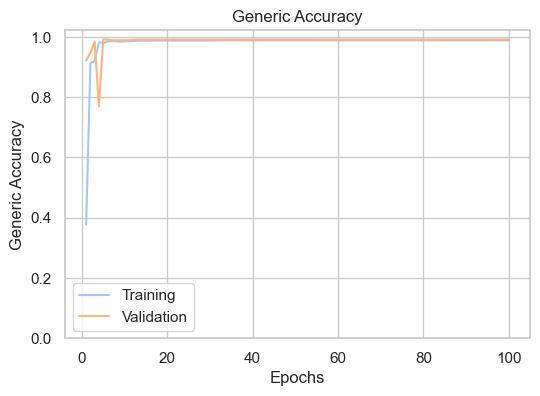

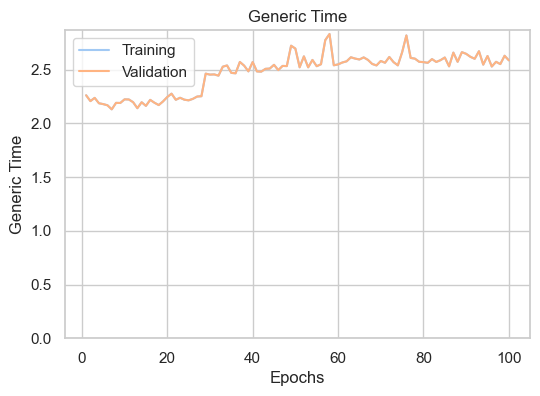

Generic Accuracy: 0.9936

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     47593
         1.0       1.00      0.99      0.99     32911

    accuracy                           0.99     80504
   macro avg       0.99      0.99      0.99     80504
weighted avg       0.99      0.99      0.99     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


Epoch [1/100], Train Loss: 0.7065, Train Accuracy: 0.0955, Train F1: 0.0475
Val Loss: 0.2349, Val Accuracy: 0.9498, Val F1: 0.9254
Epoch [2/100], Train Loss: 0.3158, Train Accuracy: 0.9083, Train F1: 0.8646
Val Loss: 0.1897, Val Accuracy: 0.9498, Val F1: 0.9254
Epoch [3/100], Train Loss: 0.3356, Train Accuracy: 0.9083, Train F1: 0.8646
Val Loss: 0.1362, Val Accuracy: 0.9498, Val F1: 0.9254
Epoch [4/100], Train Loss: 0.2205, Train Accuracy: 0.9090, Train F1: 0.8665
Val Loss: 0.2515, Val Accuracy: 0.8798, Val F1: 0.9076
Epoch [5/100], Train Loss: 0.2994, Train Accuracy: 0.8303, Train F1: 0.8586
Val Loss: 0.1387, Val Accuracy: 0.9602, Val F1: 0.9567
Epoch [6/100], Train Loss: 0.1993, Train Accuracy: 0.9120, Train F1: 0.9086
Val Loss: 0.1106, Val Accuracy: 0.9505, Val F1: 0.9278
Epoch [7/100], Train Loss: 0.1810, Train Accuracy: 0.9098, Train F1: 0.8698
Val Loss: 0.1245, Val Accuracy: 0.9500, Val F1: 0.9258
Epoch [8/100], Train Loss: 0.2015, Train Accuracy: 0.9088, Train F1: 0.8661
Val Los

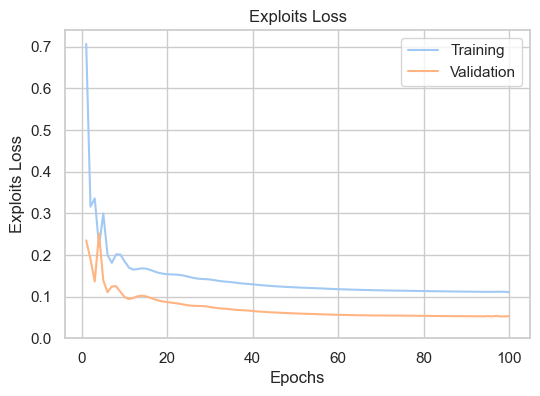

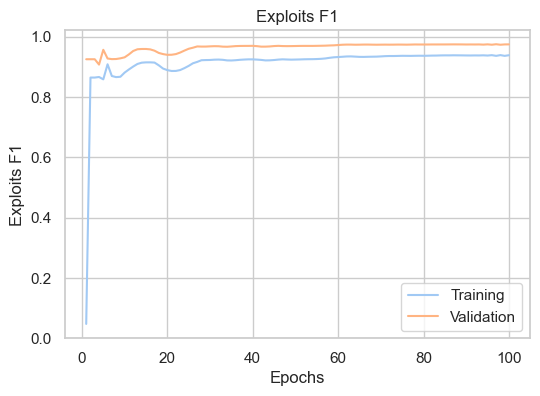

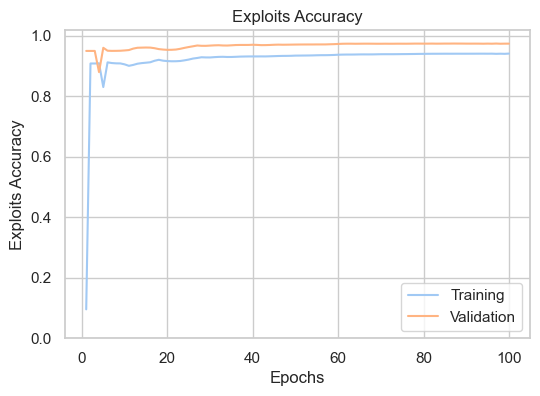

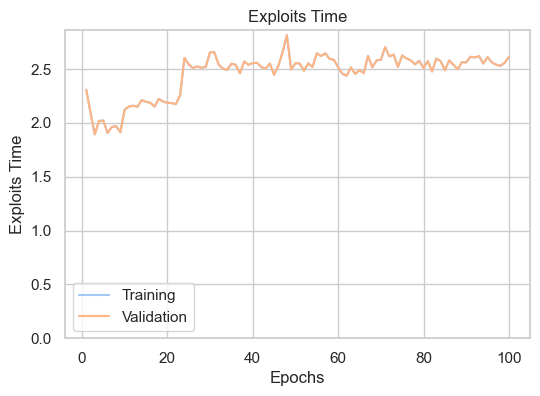

Exploits Accuracy: 0.9602

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     74478
         1.0       0.87      0.55      0.67      6026

    accuracy                           0.96     80504
   macro avg       0.92      0.77      0.83     80504
weighted avg       0.96      0.96      0.96     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


No correlations exceed the threshold.
No correlations exceed the threshold.
No correlations exceed the threshold.
Epoch [1/100], Train Loss: 0.6705, Train Accuracy: 0.9711, Train F1: 0.9569
Val Loss: 0.1604, Val Accuracy: 0.9848, Val F1: 0.9773
Epoch [2/100], Train Loss: 0.1977, Train Accuracy: 0.9711, Train F1: 0.9569
Val Loss: 0.0809, Val Accuracy: 0.9848, Val F1: 0.9773
Epoch [3/100], Train Loss: 0.1448, Train Accuracy: 0.9711, Train F1: 0.9569
Val Loss: 0.0998, Val Accuracy: 0.9848, Val F1: 0.9773
Epoch [4/100], Train Loss: 0.1827, Train Accuracy: 0.9711, Train F1: 0.9569
Val Loss: 0.0995, Val Accuracy: 0.9848, Val F1: 0.9773
Epoch [5/100], Train Loss: 0.1833, Train Accuracy: 0.9711, Train F1: 0.9569
Val Loss: 0.0846, Val Accuracy: 0.9848, Val F1: 0.9773
Epoch [6/100], Train Loss: 0.1571, Train Accuracy: 0.9711, Train F1: 0.9569
Val Loss: 0.0634, Val Accuracy: 0.9848, Val F1: 0.9773
Epoch [7/100], Train Loss: 0.1190, Train Accuracy: 0.9711, Train F1: 0.9569
Val Loss: 0.0468, Val Ac

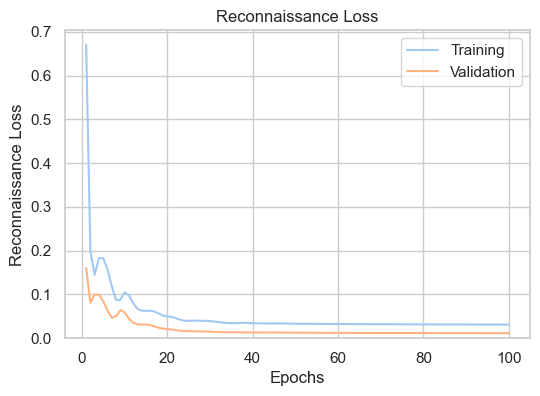

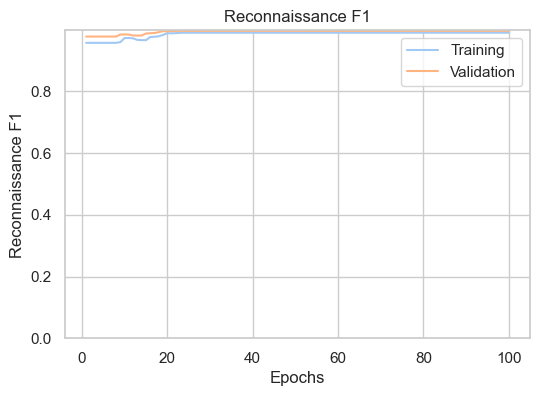

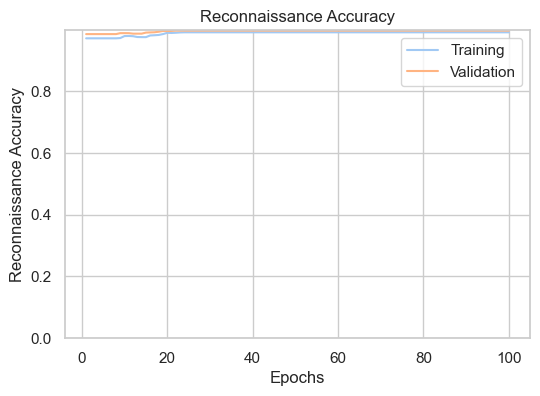

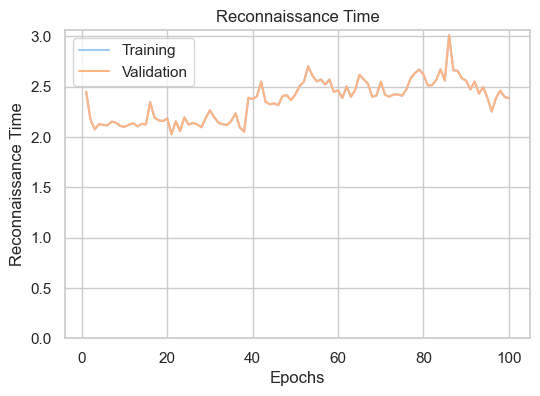

Reconnaissance Accuracy: 0.9930

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     78578
         1.0       0.92      0.77      0.84      1926

    accuracy                           0.99     80504
   macro avg       0.96      0.89      0.92     80504
weighted avg       0.99      0.99      0.99     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


No correlations exceed the threshold.
No correlations exceed the threshold.
Epoch [1/100], Train Loss: 0.7050, Train Accuracy: 0.0044, Train F1: 0.0000
Val Loss: 0.1612, Val Accuracy: 0.9958, Val F1: 0.9938
Epoch [2/100], Train Loss: 0.1687, Train Accuracy: 0.9956, Train F1: 0.9934
Val Loss: 0.0290, Val Accuracy: 0.9958, Val F1: 0.9938
Epoch [3/100], Train Loss: 0.0307, Train Accuracy: 0.9956, Train F1: 0.9934
Val Loss: 0.0362, Val Accuracy: 0.9958, Val F1: 0.9938
Epoch [4/100], Train Loss: 0.0373, Train Accuracy: 0.9956, Train F1: 0.9934
Val Loss: 0.0454, Val Accuracy: 0.9958, Val F1: 0.9938
Epoch [5/100], Train Loss: 0.0467, Train Accuracy: 0.9956, Train F1: 0.9934
Val Loss: 0.0522, Val Accuracy: 0.9958, Val F1: 0.9938
Epoch [6/100], Train Loss: 0.0538, Train Accuracy: 0.9956, Train F1: 0.9934
Val Loss: 0.0570, Val Accuracy: 0.9958, Val F1: 0.9938
Epoch [7/100], Train Loss: 0.0587, Train Accuracy: 0.9956, Train F1: 0.9934
Val Loss: 0.0600, Val Accuracy: 0.9958, Val F1: 0.9938
Epoch [

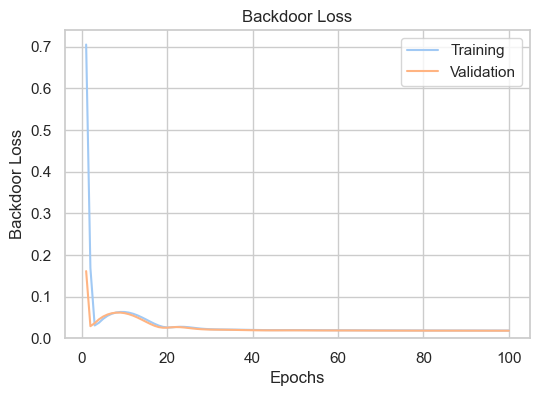

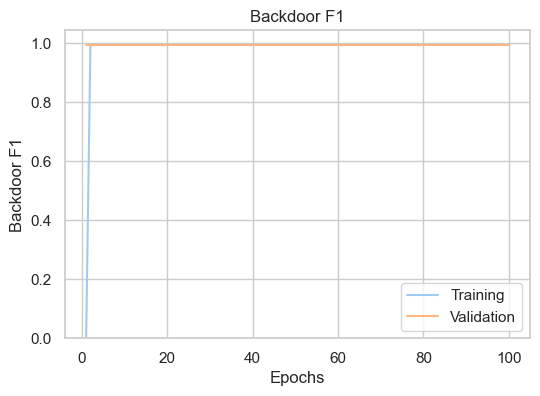

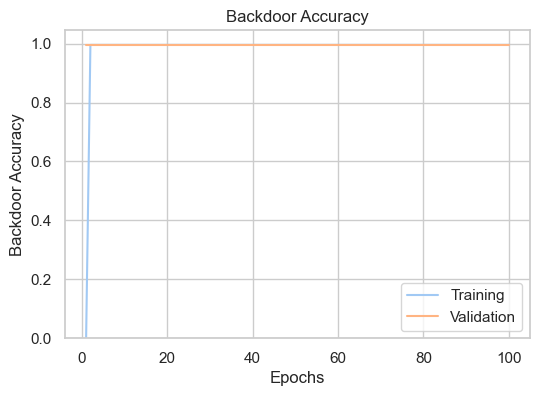

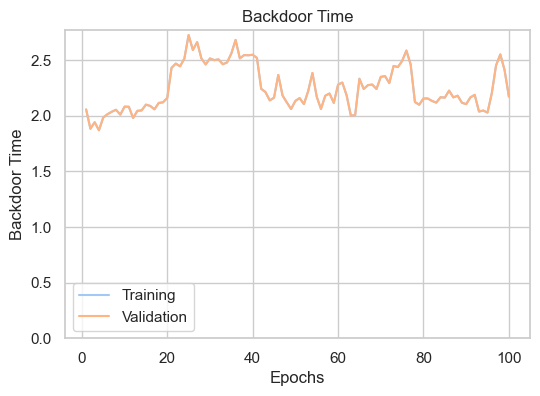

Backdoor Accuracy: 0.9961

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     80170
         1.0       0.96      0.07      0.12       334

    accuracy                           1.00     80504
   macro avg       0.98      0.53      0.56     80504
weighted avg       1.00      1.00      0.99     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


No correlations exceed the threshold.
No correlations exceed the threshold.
Epoch [1/100], Train Loss: 0.6983, Train Accuracy: 0.2297, Train F1: 0.3669
Val Loss: 0.1535, Val Accuracy: 0.9968, Val F1: 0.9953
Epoch [2/100], Train Loss: 0.1658, Train Accuracy: 0.9952, Train F1: 0.9928
Val Loss: 0.0233, Val Accuracy: 0.9968, Val F1: 0.9953
Epoch [3/100], Train Loss: 0.0327, Train Accuracy: 0.9952, Train F1: 0.9928
Val Loss: 0.0270, Val Accuracy: 0.9968, Val F1: 0.9953
Epoch [4/100], Train Loss: 0.0403, Train Accuracy: 0.9952, Train F1: 0.9928
Val Loss: 0.0333, Val Accuracy: 0.9968, Val F1: 0.9953
Epoch [5/100], Train Loss: 0.0503, Train Accuracy: 0.9952, Train F1: 0.9928
Val Loss: 0.0379, Val Accuracy: 0.9968, Val F1: 0.9953
Epoch [6/100], Train Loss: 0.0576, Train Accuracy: 0.9952, Train F1: 0.9928
Val Loss: 0.0408, Val Accuracy: 0.9968, Val F1: 0.9953
Epoch [7/100], Train Loss: 0.0625, Train Accuracy: 0.9952, Train F1: 0.9928
Val Loss: 0.0425, Val Accuracy: 0.9968, Val F1: 0.9953
Epoch [

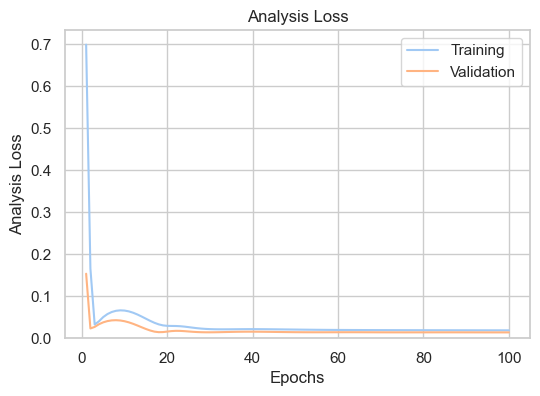

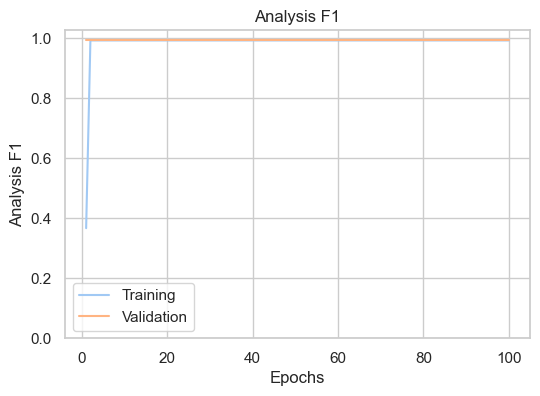

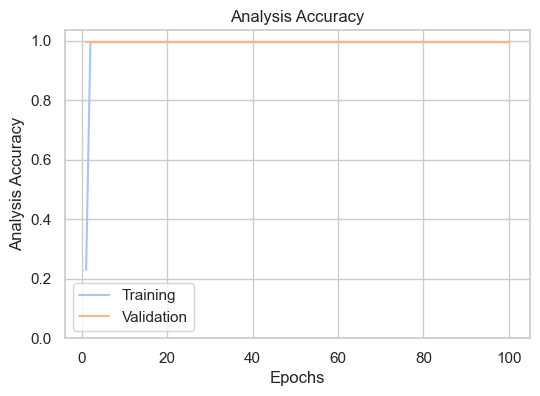

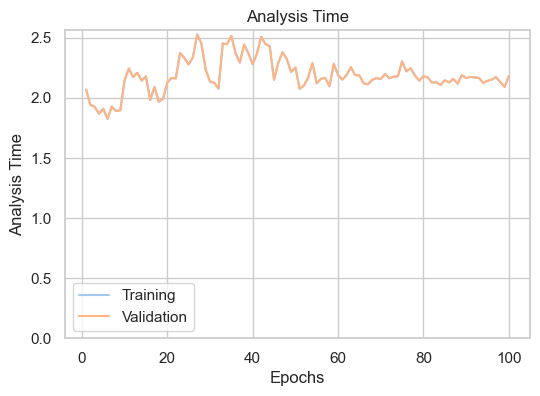

Analysis Accuracy: 0.9924

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     79895
         1.0       0.44      0.01      0.01       609

    accuracy                           0.99     80504
   macro avg       0.72      0.50      0.50     80504
weighted avg       0.99      0.99      0.99     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


No correlations exceed the threshold.
No correlations exceed the threshold.
No correlations exceed the threshold.
No correlations exceed the threshold.
No correlations exceed the threshold.
Epoch [1/100], Train Loss: 0.6873, Train Accuracy: 0.9006, Train F1: 0.9454
Val Loss: 0.2258, Val Accuracy: 0.9951, Val F1: 0.9927
Epoch [2/100], Train Loss: 0.1797, Train Accuracy: 0.9975, Train F1: 0.9963
Val Loss: 0.0406, Val Accuracy: 0.9951, Val F1: 0.9927
Epoch [3/100], Train Loss: 0.0217, Train Accuracy: 0.9975, Train F1: 0.9963
Val Loss: 0.0366, Val Accuracy: 0.9951, Val F1: 0.9927
Epoch [4/100], Train Loss: 0.0186, Train Accuracy: 0.9975, Train F1: 0.9963
Val Loss: 0.0463, Val Accuracy: 0.9951, Val F1: 0.9927
Epoch [5/100], Train Loss: 0.0237, Train Accuracy: 0.9975, Train F1: 0.9963
Val Loss: 0.0552, Val Accuracy: 0.9951, Val F1: 0.9927
Epoch [6/100], Train Loss: 0.0282, Train Accuracy: 0.9975, Train F1: 0.9963
Val Loss: 0.0624, Val Accuracy: 0.9951, Val F1: 0.9927
Epoch [7/100], Train Los

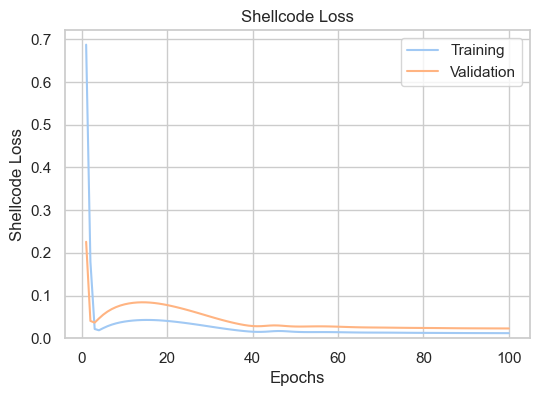

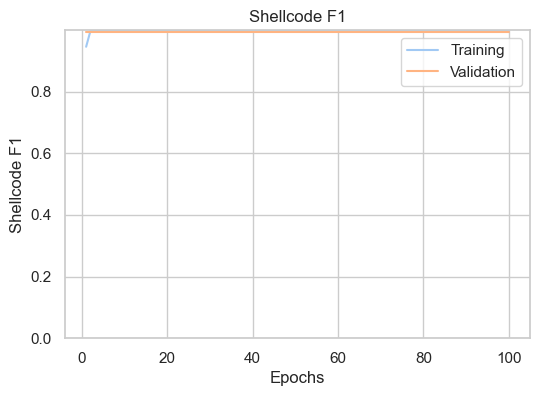

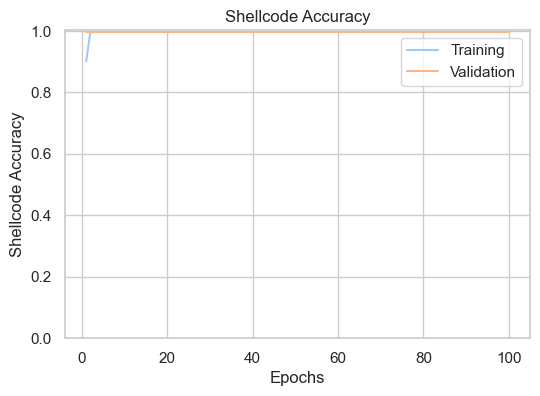

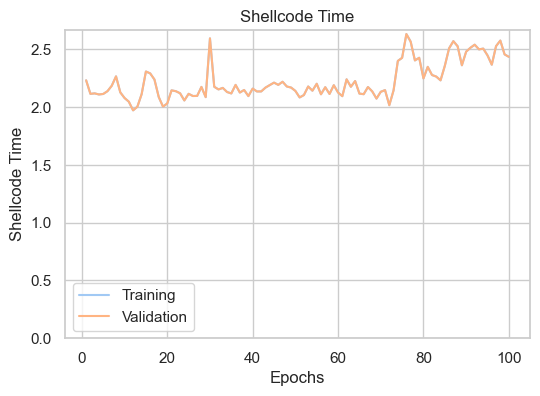

Shellcode Accuracy: 0.9982

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     80307
         1.0       0.77      0.37      0.50       197

    accuracy                           1.00     80504
   macro avg       0.88      0.69      0.75     80504
weighted avg       1.00      1.00      1.00     80504



C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:45: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_5844\753908975.py:50: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


No correlations exceed the threshold.
No correlations exceed the threshold.
No correlations exceed the threshold.
No correlations exceed the threshold.
No correlations exceed the threshold.
Epoch [1/100], Train Loss: 0.6837, Train Accuracy: 0.8433, Train F1: 0.9146
Val Loss: 0.1535, Val Accuracy: 0.9998, Val F1: 0.9997
Epoch [2/100], Train Loss: 0.1675, Train Accuracy: 0.9996, Train F1: 0.9995
Val Loss: 0.0077, Val Accuracy: 0.9998, Val F1: 0.9997
Epoch [3/100], Train Loss: 0.0108, Train Accuracy: 0.9996, Train F1: 0.9995
Val Loss: 0.0022, Val Accuracy: 0.9998, Val F1: 0.9997
Epoch [4/100], Train Loss: 0.0036, Train Accuracy: 0.9996, Train F1: 0.9995
Val Loss: 0.0024, Val Accuracy: 0.9998, Val F1: 0.9997
Epoch [5/100], Train Loss: 0.0040, Train Accuracy: 0.9996, Train F1: 0.9995
Val Loss: 0.0029, Val Accuracy: 0.9998, Val F1: 0.9997
Epoch [6/100], Train Loss: 0.0048, Train Accuracy: 0.9996, Train F1: 0.9995
Val Loss: 0.0033, Val Accuracy: 0.9998, Val F1: 0.9997
Epoch [7/100], Train Los

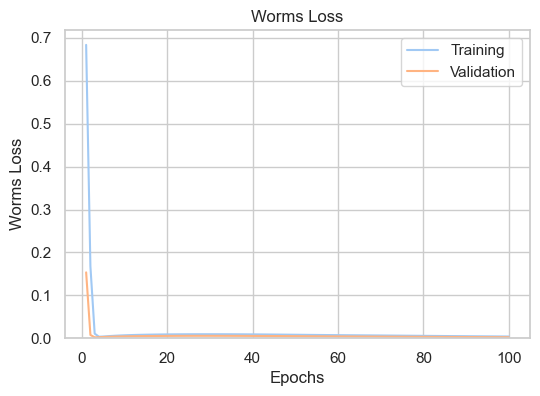

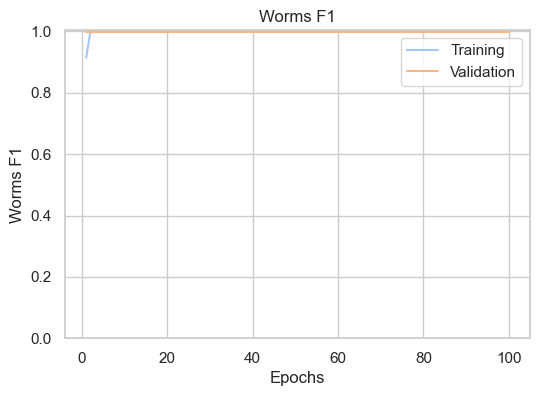

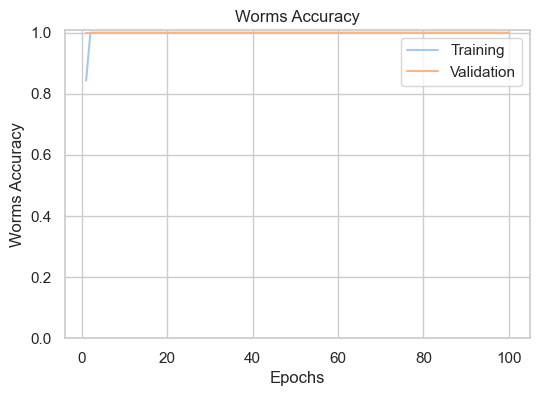

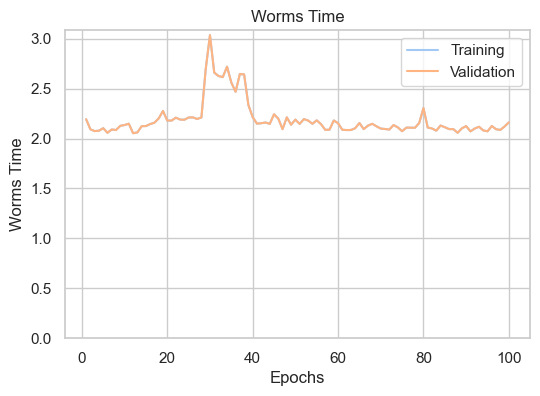

Worms Accuracy: 0.9997

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     80479
         1.0       0.33      0.12      0.18        25

    accuracy                           1.00     80504
   macro avg       0.67      0.56      0.59     80504
weighted avg       1.00      1.00      1.00     80504

Average LSTM Accuracy
0.9865693354091446
Average Random Forest Accuracy
0.9884477789923483


In [31]:
labels = ['DoS', 'Fuzzers', 'Generic', 'Exploits', 'Reconnaissance', 'Backdoor', 'Analysis', 'Shellcode', 'Worms']
be = BinaryEnsembler(labels, 128, 1, 100, 0.1, 0.07)